In [ ]:
# %pip install tensorflow numpy scikit-learn matplotlib seaborn

In [1]:
import tensorflow as tf # type: ignore
import numpy as np # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array # type: ignore
from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras import layers, Model # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Ensure the models directory exists
os.makedirs('models', exist_ok=True)

In [3]:
# Define class mappings for ADNI dataset
label_to_class = {'Mild_Demented': 0, 'Moderate_Demented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)
target_names = list(label_to_class.keys())

# Input sizes
w_hybrid, h_hybrid = 128, 128  # For Hybrid ResNet+ViT
w_vit, h_vit = 224, 224        # For Vision Transformer

In [4]:
def get_images(dir_name='content', label_to_class=None, target_size=(128, 128)):
    Images = []
    Classes = []
    for j in ['/train', '/test']:
        for label_name in os.listdir(dir_name + j):
            cls = label_to_class[label_name]
            class_path = os.path.join(dir_name + j, label_name)
            for img_name in os.listdir(class_path):
                img = load_img(os.path.join(class_path, img_name), target_size=target_size)
                img = img_to_array(img) / 255.0  # Normalize to [0,1]
                Images.append(img)
                Classes.append(cls)
    
    # Convert to NumPy arrays
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.int32)
    
    # Shuffle using indices
    indices = np.random.permutation(len(Images))
    shuffled_Images = Images[indices]
    shuffled_Classes = Classes[indices]
    
    return shuffled_Images, shuffled_Classes

In [5]:
# Load datasets
Images_hybrid, Classes_hybrid = get_images(label_to_class=label_to_class, target_size=(w_hybrid, h_hybrid))  # For Hybrid
Images_vit, Classes_vit = get_images(label_to_class=label_to_class, target_size=(w_vit, h_vit))              # For ViT

# Split data
def split_data(Images, Classes, train_size=0.7, val_size=0.1, test_size=0.2):
    x_train, x_temp, y_train, y_temp = train_test_split(Images, Classes, train_size=train_size, shuffle=True)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=test_size/(val_size + test_size), shuffle=True)
    y_train = to_categorical(y_train, num_classes=n_classes)
    y_val = to_categorical(y_val, num_classes=n_classes)
    y_test = to_categorical(y_test, num_classes=n_classes)
    return x_train, y_train, x_val, y_val, x_test, y_test

# Split datasets
x_train_h, y_train_h, x_val_h, y_val_h, x_test_h, y_test_h = split_data(Images_hybrid, Classes_hybrid)
x_train_v, y_train_v, x_val_v, y_val_v, x_test_v, y_test_v = split_data(Images_vit, Classes_vit)

In [6]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True
)

In [7]:
# Model configurations
config_hybrid = {
    "num_layers": 6, "hidden_dim": 64, "mlp_dim": 2048, "num_heads": 8, "dropout_rate": 0.2,
    "image_size": 128, "patch_size": 32, "num_patches": int((128 / 32) ** 2), "num_channels": 3, "num_classes": 4
}
config_vit = {
    "num_layers": 6, "hidden_dim": 64, "mlp_dim": 2048, "num_heads": 8, "dropout_rate": 0.2,
    "image_size": 224, "patch_size": 32, "num_patches": int((224 / 32) ** 2), "num_channels": 3, "num_classes": 4
}

# Custom Class Token Layer
class ClassToken(tf.keras.layers.Layer):
    def __init__(self, trainable=True, **kwargs):
        super(ClassToken, self).__init__(trainable=trainable, **kwargs)
        self.cls_token = None  # Initialized in build

    def build(self, input_shape):
        # Initialize the class token as a learnable parameter
        # Shape: (1, 1, input_dim) where input_dim is the feature dimension
        self.cls_token = self.add_weight(
            shape=(1, 1, input_shape[-1]),
            initializer='zeros',
            trainable=True,
            name='cls_token'
        )
        super(ClassToken, self).build(input_shape)

    def call(self, inputs):
        # Get the batch size dynamically from the input tensor
        batch_size = tf.shape(inputs)[0]
        # Tile the class token to match the batch size
        cls_token = tf.tile(self.cls_token, [batch_size, 1, 1])
        # Concatenate the class token to the input sequence along the sequence axis
        return tf.concat([cls_token, inputs], axis=1)

    def get_config(self):
        # Serialize the layer’s configuration
        config = super(ClassToken, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        # Deserialize the layer from its configuration
        return cls(**config)

# Transformer components
def mlp(x, cf):
    x = layers.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = layers.Dropout(cf["dropout_rate"])(x)
    x = layers.Dense(cf["hidden_dim"])(x)
    x = layers.Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = layers.LayerNormalization()(x)
    x = layers.MultiHeadAttention(num_heads=cf["num_heads"], key_dim=cf["hidden_dim"])(x, x)
    x = layers.Add()([x, skip_1])
    skip_2 = x
    x = layers.LayerNormalization()(x)
    x = mlp(x, cf)
    x = layers.Add()([x, skip_2])
    return x

# Hybrid ResNet+ViT Model
def ResNet50ViT(cf):
    inputs = layers.Input(shape=(cf["image_size"], cf["image_size"], cf["num_channels"]))
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    output = resnet50.output
    patch_embed = layers.Conv2D(cf["hidden_dim"], kernel_size=cf["patch_size"], padding="same")(output)
    _, h, w, f = patch_embed.shape
    patch_embed = layers.Reshape((h * w, f))(patch_embed)
    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = layers.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions)
    embed = patch_embed + pos_embed
    token = ClassToken()(embed)
    x = layers.Concatenate(axis=1)([token, embed])
    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)
    x = layers.LayerNormalization()(x)
    x = x[:, 0, :]
    logits = layers.Dense(cf["num_classes"])(x)
    return Model(inputs, logits)

# Solo Vision Transformer Model
def VisionTransformer(cf):
    inputs = layers.Input(shape=(cf["image_size"], cf["image_size"], cf["num_channels"]))
    patches = layers.Conv2D(cf["hidden_dim"], kernel_size=cf["patch_size"], strides=cf["patch_size"])(inputs)
    patches = layers.Reshape((cf["num_patches"], cf["hidden_dim"]))(patches)
    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = layers.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions)
    embed = patches + pos_embed
    token = ClassToken()(embed)
    x = layers.Concatenate(axis=1)([token, embed])
    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)
    x = layers.LayerNormalization()(x)
    x = x[:, 0, :]
    logits = layers.Dense(cf["num_classes"])(x)
    return Model(inputs, logits)

In [ ]:
def run_experiment(model, train_data, val_data, weights_filepath, model_filepath, epochs):
    # Compile the model
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00005, weight_decay=0.0001)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")]
    )
    
    # Define the ModelCheckpoint callback with the weights filepath
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        weights_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True
    )
    
    # Train the model
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        callbacks=[checkpoint_callback]
    )
    
    # Load the best weights saved by ModelCheckpoint
    model.load_weights(weights_filepath)
    
    # Save the full model to the model filepath
    model.save(model_filepath)

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Training_accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation_accuracy')
    plt.legend()
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('No. of epochs')  # Adjusted to "No. of epochs" for readability
    plt.ylabel('Accuracy')
    plt.savefig(f'{model_filepath}_Accuracy_Graph.png')  # Save before showing
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Training_loss')
    plt.plot(history.history['val_loss'], label='Validation_loss')
    plt.legend()
    plt.title('Training Loss vs Validation Loss')  # Capitalized "Loss" for consistency
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.savefig(f'{model_filepath}_Loss_Graph.png')  # Save before showing
    plt.show()
    
    return history, model




Training Hybrid ResNet+ViT Model:
Epoch 1/20
252/252 [==============================] - 1493s 6s/step - loss: 0.9847 - accuracy: 0.5317 - val_loss: 1.0458 - val_accuracy: 0.3455
Epoch 2/20
252/252 [==============================] - 1472s 6s/step - loss: 0.8396 - accuracy: 0.5977 - val_loss: 1.0652 - val_accuracy: 0.5191
Epoch 3/20
252/252 [==============================] - 1473s 6s/step - loss: 0.7507 - accuracy: 0.6637 - val_loss: 1.5653 - val_accuracy: 0.5191
Epoch 4/20
252/252 [==============================] - 1473s 6s/step - loss: 0.6814 - accuracy: 0.7068 - val_loss: 0.9086 - val_accuracy: 0.5816
Epoch 5/20
252/252 [==============================] - 1471s 6s/step - loss: 0.5788 - accuracy: 0.7545 - val_loss: 0.7090 - val_accuracy: 0.7014
Epoch 6/20
252/252 [==============================] - 1470s 6s/step - loss: 0.4904 - accuracy: 0.8048 - val_loss: 0.7001 - val_accuracy: 0.7205
Epoch 7/20
252/252 [==============================] - 1475s 6s/step - loss: 0.4114 - accuracy: 0.8351

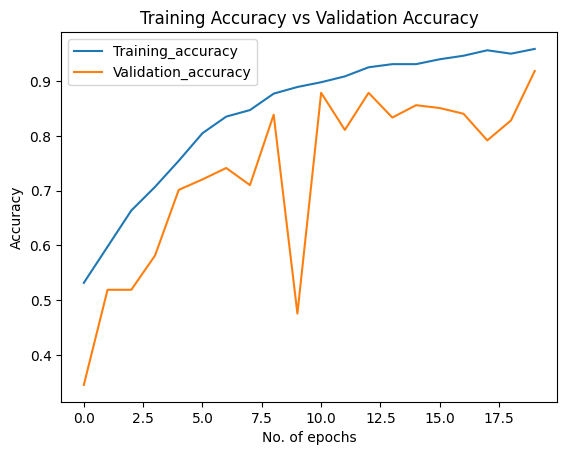

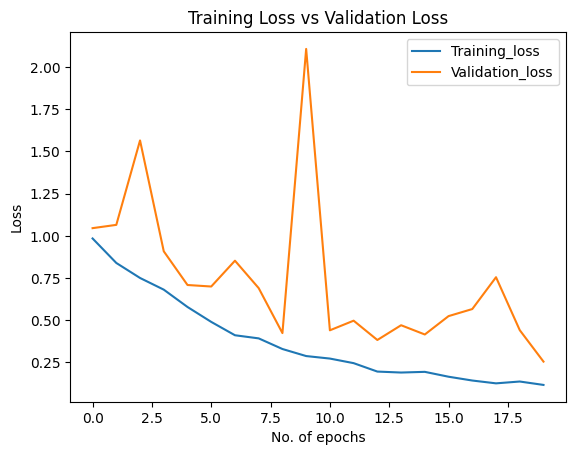

Hybrid Model trained and saved in models


In [9]:
# Build and train models
hybrid_model = ResNet50ViT(config_hybrid)

# Train Hybrid Model
print("\nTraining Hybrid ResNet+ViT Model:")
train_generator_h = train_datagen.flow(x_train_h, y_train_h, batch_size=16)
history_hybrid, hybrid_model = run_experiment(
    hybrid_model,
    train_generator_h,
    (x_val_h, y_val_h),
    weights_filepath="models/hybrid_weights.weights.h5",
    model_filepath="models/hybrid_model.keras",
    epochs = 20
)

print("Hybrid Model trained and saved in models")


Training Vision Transformer Model:
Epoch 1/100
252/252 [==============================] - 156s 589ms/step - loss: 1.0846 - accuracy: 0.4804 - val_loss: 1.0154 - val_accuracy: 0.4878
Epoch 2/100
252/252 [==============================] - 146s 581ms/step - loss: 1.0507 - accuracy: 0.4916 - val_loss: 0.9972 - val_accuracy: 0.5000
Epoch 3/100
252/252 [==============================] - 146s 579ms/step - loss: 1.0164 - accuracy: 0.5072 - val_loss: 0.9816 - val_accuracy: 0.5122
Epoch 4/100
252/252 [==============================] - 143s 569ms/step - loss: 1.0089 - accuracy: 0.5181 - val_loss: 0.9716 - val_accuracy: 0.5052
Epoch 5/100
252/252 [==============================] - 145s 576ms/step - loss: 0.9882 - accuracy: 0.5146 - val_loss: 1.0256 - val_accuracy: 0.4809
Epoch 6/100
252/252 [==============================] - 145s 575ms/step - loss: 0.9837 - accuracy: 0.5107 - val_loss: 0.9976 - val_accuracy: 0.4983
Epoch 7/100
252/252 [==============================] - 145s 574ms/step - loss: 0.9

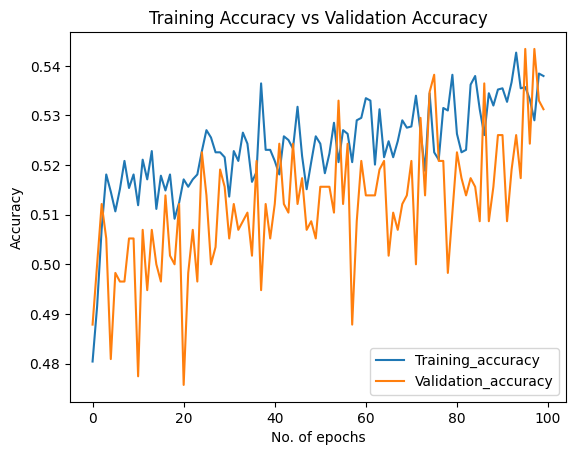

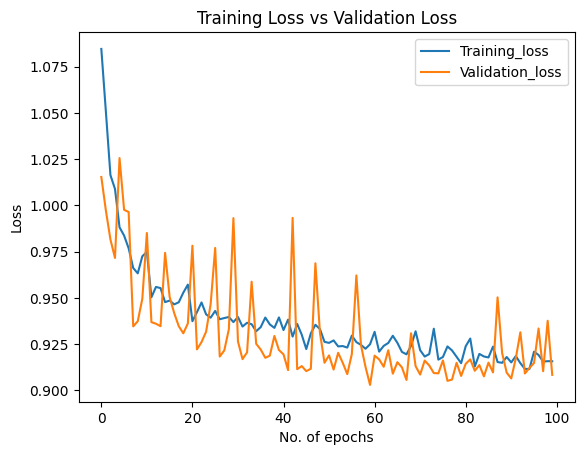

ViT Model trained and saved in models


In [10]:
# Build and train models
vit_model = VisionTransformer(config_vit)

# Train ViT Model
print("\nTraining Vision Transformer Model:")
train_generator_v = train_datagen.flow(x_train_v, y_train_v, batch_size=16)
history_vit, vit_model = run_experiment(
    vit_model, 
    train_generator_v, 
    (x_val_v, y_val_v),
    weights_filepath="models/vit_weights.weights.h5",
    model_filepath="models/vit_model.keras",
    epochs = 100
)
print("ViT Model trained and saved in models")

In [11]:
# Define model directory
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
# Save the final hybrid model after training
hybrid_model.save(os.path.join(model_dir, "hybrid_model_fianll.keras"))

# Save the final ViT model after training
vit_model.save(os.path.join(model_dir, "vit_model_finall.keras"))

Testing the models


--- Testing Saved Models ---
37/37 [==============================] - 32s 815ms/step

ResNet+ViT Model - Confusion Matrix:
[[144   0   5  12]
 [  0   8   1   0]
 [ 15   0 544  16]
 [  5   0  39 364]]

ResNet+ViT Model - Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented      0.878     0.894     0.886       161
 Moderate_Demented      1.000     0.889     0.941         9
      Non_Demented      0.924     0.946     0.935       575
Very_Mild_Demented      0.929     0.892     0.910       408

          accuracy                          0.919      1153
         macro avg      0.933     0.905     0.918      1153
      weighted avg      0.920     0.919     0.919      1153

ResNet+ViT Model - Metrics (Macro-Averaged):
  Accuracy: 0.919
  Precision: 0.933
  Recall: 0.905
Specificity: 0.966
  F1 Score: 0.918


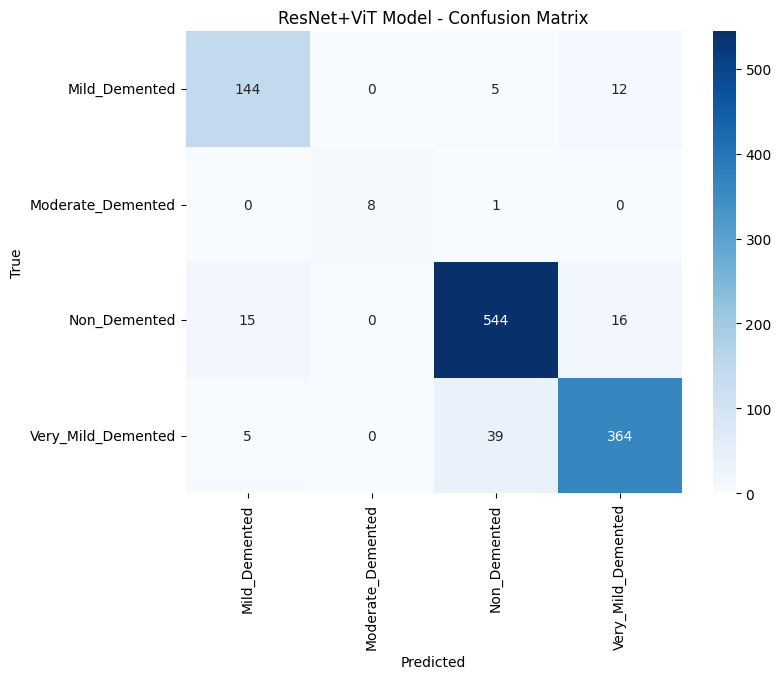

37/37 [==============================] - 13s 343ms/step

Vision Transformer Model - Confusion Matrix:
[[  0   0  34 145]
 [  0   0   1   6]
 [  0   0 395 151]
 [  0   0 165 256]]

Vision Transformer Model - Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented      0.000     0.000     0.000       179
 Moderate_Demented      0.000     0.000     0.000         7
      Non_Demented      0.664     0.723     0.692       546
Very_Mild_Demented      0.459     0.608     0.523       421

          accuracy                          0.565      1153
         macro avg      0.281     0.333     0.304      1153
      weighted avg      0.482     0.565     0.519      1153

Vision Transformer Model - Metrics (Macro-Averaged):
  Accuracy: 0.565
  Precision: 0.281
  Recall: 0.333
Specificity: 0.814
  F1 Score: 0.304


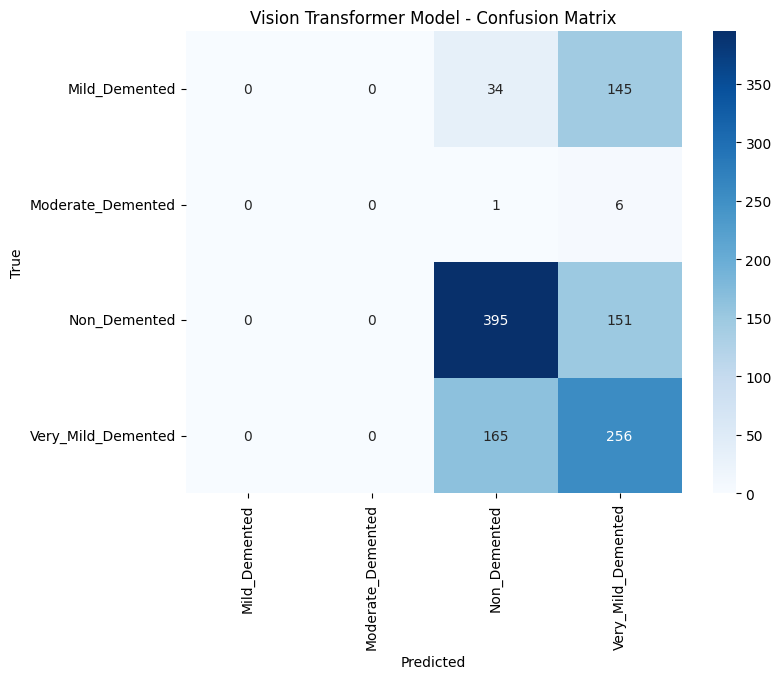

In [13]:
import tensorflow as tf # type: ignore
import numpy as np # type: ignore
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt

# Define class mappings (same as training)
label_to_class = {'Mild_Demented': 0, 'Moderate_Demented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}
target_names = list(label_to_class.keys())

def compute_specificity(cm):
    specificities = []
    for i in range(len(cm)):
        TN = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
        FP = np.sum(cm[:, i]) - cm[i, i]
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities.append(specificity)
    return np.mean(specificities)

# Evaluation function
def evaluate_model(model, x_test, y_test, target_names, model_name):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print(f"\n{model_name} - Confusion Matrix:")
    print(cm)
    report = classification_report(y_true_classes, y_pred_classes, target_names=target_names, digits=3)
    print(f"\n{model_name} - Classification Report:")
    print(report)
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='macro')
    recall = recall_score(y_true_classes, y_pred_classes, average='macro')
    f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
    specificity = compute_specificity(cm)
    print(f"{model_name} - Metrics (Macro-Averaged):")
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"  F1 Score: {f1:.3f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Your load_and_test_model function
def load_and_test_model(model_path, x_test, y_test, target_names, model_name):
    model = tf.keras.models.load_model(model_path, custom_objects={'ClassToken': ClassToken})
    evaluate_model(model, x_test, y_test, target_names, model_name)

# Assuming test data is available (load or define x_test_h, y_test_h, x_test_v, y_test_v here if not in scope)
# For example, if you have saved test data separately, load it; otherwise, ensure it's passed from training
# Placeholder: Replace with actual test data loading if needed
# x_test_h, y_test_h = load_test_data_for_hybrid()  # Define this if needed
# x_test_v, y_test_v = load_test_data_for_vit()    # Define this if needed

# Test the saved models
print("\n--- Testing Saved Models ---")
load_and_test_model('models/hybrid_model_fianll.keras', x_test_h, y_test_h, target_names, "ResNet+ViT Model")
load_and_test_model('models/vit_model_finall.keras', x_test_v, y_test_v, target_names, "Vision Transformer Model")